In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import yaml
import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

import wandb
from torchsummary import summary
from sklearn.decomposition import PCA
from torchvision.utils import make_grid


from seismic import build_model
from seismic.utils import ema_smoothing, set_optim_lr

sys.path.append("/home/dp4018/scripts/InverseLDM/")
from invldm.datasets.brain2d_dataset import Brain2DDataset
from invldm.utils.visualisation import OSCAR_CMAP, visualise_samples
from invldm.utils.utils import namespace2dict, dict2namespace, scale2range
from invldm.utils.setup import set_seed


set_seed(42)

%autoreload 2

DEVICE="cuda:1"

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dekape. Use `wandb login --relogin` to force relogin


True

In [15]:
dataset_args = dict2namespace(dict(
    data_path="/home/dp4018/data/ultrasound-data/Ultrasound-Vp-sagittal-models/",
    mode="vp",
    maxsamples=None,
    slowness=False,
    resize=[256, 256],
    scale=[0., 1.],
    clip_outliers=None,
    to_tensor=False,
    normalise=(0.10280502008738208, 0.22698244373387108),
    antialias=True,
    condition = dict(
        mode="stack-stack-pca-single-256x256",
        path="/home/dp4018/data/ultrasound-data/Ultrasound-Vp-sagittal-data/acoustic/data/stack_pca_single/data",
        # mode="stack",
        # path="/home/dp4018/data/ultrasound-data/Ultrasound-Vp-sagittal-data/acoustic/data/stack/",
        # resize=[256, 256],
        # scale=[0., 1.],
        clip_outliers=False,
        to_tensor=False,
        normalise=False,
        antialias=True,

    ),
    sampling_only=False,
    batch_size=8,
))

dataset = Brain2DDataset(dataset_args)
sampler = torch.utils.data.RandomSampler(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=dataset_args.batch_size, sampler=sampler)

-0.4529205800952489 3.9527064963867753 0.006281505046853462 0.0 1.0 0.45998282268923585


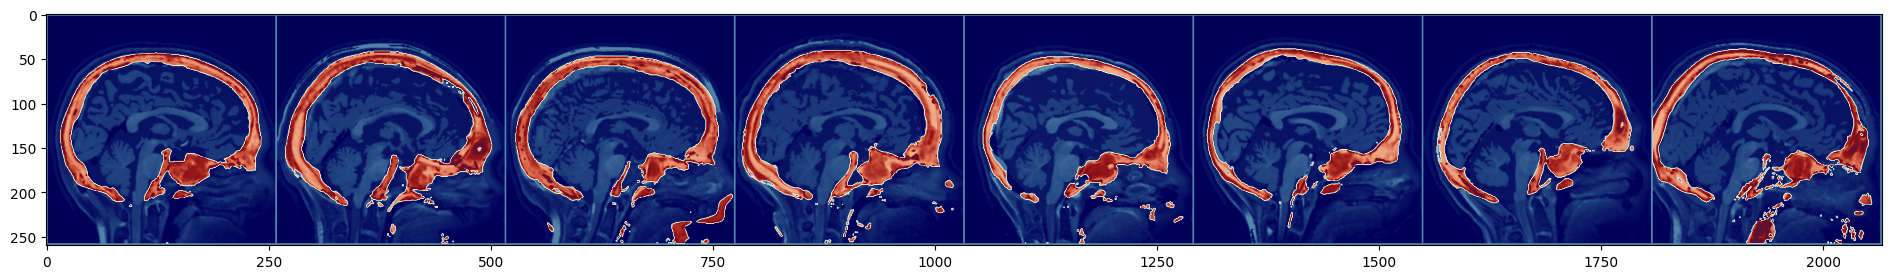

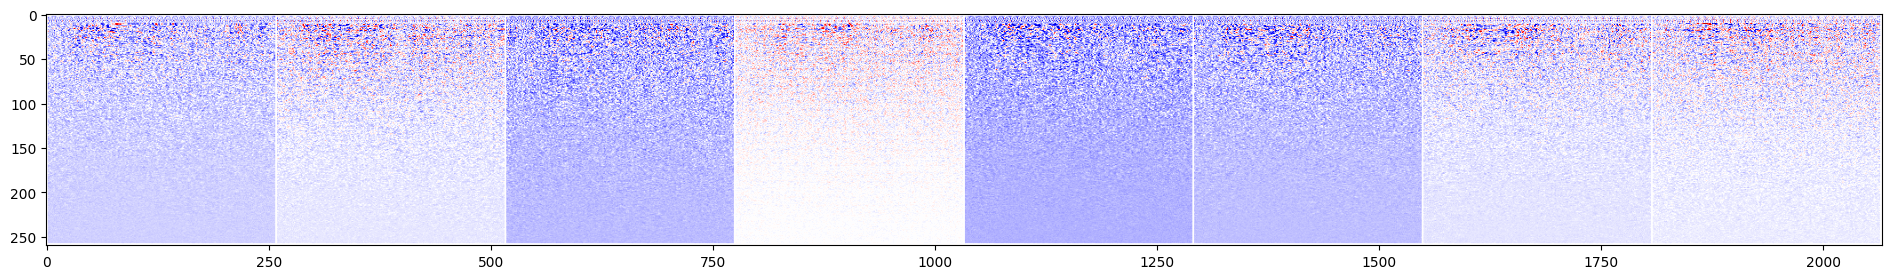

In [16]:
img, data = next(iter(dataloader))

print(img.min().item(), img.max().item(), img.mean().item(), data.min().item(), data.max().item(), data.mean().item())


fig = plt.figure(figsize=(24, 3))
plt.imshow(make_grid(torch.rot90(img, dims=[2, 3]))[0], cmap=OSCAR_CMAP); plt.show()


fig = plt.figure(figsize=(24, 3))
data_plt = make_grid(scale2range(torch.transpose(data, 2, 3), [-1, 1]))[0]
plt.imshow(data_plt, cmap="seismic", vmin=-1., vmax=1.); plt.show()

In [17]:
dataset.info(nsamples=1000)

{'max': 3.9527064963867753,
 'min': -0.4529205800952489,
 'mean': -0.0018673466785810357,
 'std': 1.0003630907076595,
 'shape': torch.Size([1, 256, 256])}

In [6]:
# embed_dim = 256
embed_dim = 4
embed_size = 32
images_resolution = img.shape[2]
images_channels = 1
data_resolution = data.shape[2]
data_channels = 1
vision_layers = 4
vision_width = 256
vision_patch_size = 3
mixed_precision = False

model = build_model(
    embed_dim,
    embed_size,
    images_resolution,
    images_channels,
    data_resolution,
    data_channels,
    vision_layers,
    vision_width,
    vision_patch_size,
    mixed_precision
).to(DEVICE)

_ = summary(model)

img_f, data_f, img_logit, data_logit = model(img.to(DEVICE), data.to(DEVICE))

print("\n================ LOGITS ==================")
print(img_logit.shape, data_logit.shape)
print(img_logit.min().item(), img_logit.max().item(), img_logit.mean().item())
print(data_logit.min().item(), data_logit.max().item(), data_logit.mean().item())

print("\n================ FEATURES ================")
print(img_f.shape, data_f.shape)
print(img_f.min().item(), img_f.max().item(), img_f.mean().item())
print(data_f.min().item(), data_f.max().item(), data_f.mean().item())

del img_f, data_f, img_logit, data_logit

save_freq = 500


n_epochs = 450
warm_restart_steps = 2000
bias_weight_decay = False
loss_fn = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.98), eps=1e-6)#, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimiser, warm_restart_steps)
scheduler = None
losses = []


Layer (type:depth-idx)                             Param #
├─VisionTransformer: 1-1                           --
|    └─Conv2d: 2-1                                 2,304
|    └─LayerNorm: 2-2                              512
|    └─Transformer: 2-3                            --
|    |    └─Sequential: 3-1                        3,159,040
|    └─LayerNorm: 2-4                              512
|    └─Conv2d: 2-5                                 16
├─VisionTransformer: 1-2                           --
|    └─Conv2d: 2-6                                 2,304
|    └─LayerNorm: 2-7                              512
|    └─Transformer: 2-8                            --
|    |    └─Sequential: 3-2                        3,159,040
|    └─LayerNorm: 2-9                              512
|    └─Conv2d: 2-10                                16
Total params: 6,324,768
Trainable params: 6,324,768
Non-trainable params: 0

================ LOGITS ==================
torch.Size([8, 8]) torch.Size([8, 8])
0.1

 10%|█         | 46/450 [58:57<8:37:44, 76.89s/it] 


train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
train/train_loss,▁█▆███████████████▆▆████████████████████
train/epoch,46
train/train_loss,2.08008


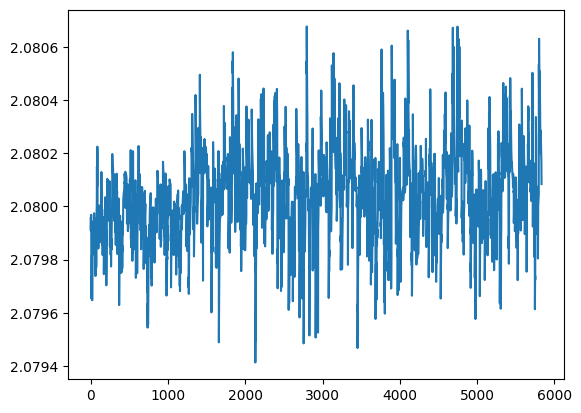

tensor(2.0801, device='cuda:1', grad_fn=<MulBackward0>)


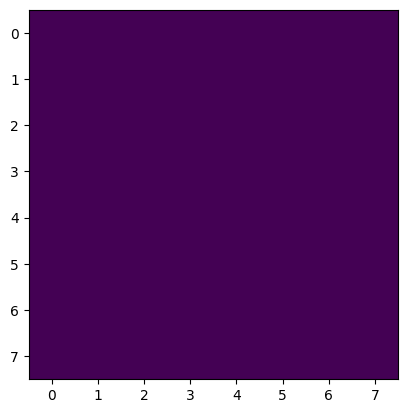

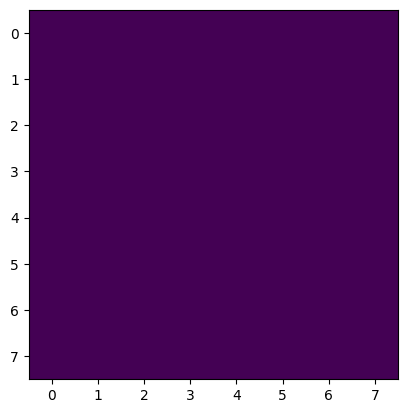

In [7]:
# # Initialise Weights and Biases and store hyperparameters
# wandb_run = wandb.init(
#     project="SeismicClip",
#     save_code=True,
#     group="hyper_tune",
#     dir="./exps",
#     config={
#         "data":namespace2dict(dataset_args),
#         "training":{
#             "epochs": n_epochs,
#         },
#         "model": {
#             "embed_dim": embed_dim,
#             "embed_size": embed_size,
#             "images_resolution": images_resolution,
#             "images_channels": images_channels,
#             "data_resolution": data_resolution,
#             "data_channels": data_channels,
#             "vision_layers": vision_layers,
#             "vision_width": vision_width,
#             "vision_patch_size": vision_patch_size,
#             "mixed_precision": mixed_precision,
#             # "comment": "original clip parameters (some scaling by 4 given the data dimension)",
#             "loss_fn": str(loss_fn)
#         },
#         "optim":{
#             "optimiser": {"name":optimiser.__class__.__name__,
#                         "betas": optimiser.defaults["betas"],
#                         "weight_decay": optimiser.defaults["weight_decay"],
#                         "eps": optimiser.defaults["eps"]},
#             "bias_weight_decay": bias_weight_decay if optimiser.defaults["weight_decay"] > 0 else "N/A",
#             "lr": optimiser.defaults["lr"],
#             "lr_sched": scheduler,
#             "warm_restart_steps": warm_restart_steps,
#         },
#     },
# )

# # Create exp folder and save config
# os.mkdir(f"./exps/{wandb_run.name}")
# os.mkdir(f"./exps/{wandb_run.name}/embeddings")
# with open(os.path.join(f"./exps/{wandb_run.name}", "config_training.yml"), "w") as f:
#     yaml.dump(dict(wandb_run.config.items()), f, default_flow_style=False, sort_keys=False, indent=4)


# # Change weight decay of biases to zero if prompted
# if not bias_weight_decay and optimiser.defaults["weight_decay"] > 0:
#     decay_params, no_decay_params = [], []
#     for name, param in model.named_parameters():
#         if not param.requires_grad:
#             continue           
#         elif len(param.shape) == 1 or name.endswith(".bias"):
#             no_decay_params.append(param)
#         else: decay_params.append(param)
#     params = [{'params': no_decay_params, 'weight_decay': 0.}, {'params': decay_params, 'weight_decay': optimiser.defaults["weight_decay"]}]        
# else:
#     params=model.parameters()
# optimiser = torch.optim.Adam(params, **optimiser.defaults)

# # Step count
# step = 0

# # Train
# try:
#     for epoch in tqdm(range(n_epochs)):
#         for img, data in dataloader:
#             with torch.autocast(device_type="cuda" if "cuda" in DEVICE else "cpu"):
#                 # Get logits
#                 _, _, logit_im, logit_dt = model(img.to(DEVICE), data.to(DEVICE))

#                 # Compute  loss
#                 targets = torch.arange(img.shape[0]).to(DEVICE)
#                 loss = 0.5*(loss_fn(logit_im, targets) + loss_fn(logit_dt, targets))
                
#             # Store loss
#             losses.append(loss.item())

#             # Log wandb
#             wandb.log({
#                 "train/train_loss": loss,
#                 "train/epoch": epoch,
#             })
#             if step % save_freq == 0 or step == n_epochs*len(dataloader)-1:
#                 w_logit_im = wandb.Image(logit_im, caption=f"Logits of Images - step {step}")
#                 w_logit_dt = wandb.Image(logit_dt, caption=f"Logits of Data - step {step}")
#                 wandb.log({
#                     "train/logit_images": w_logit_im,
#                     "train/logit_data": w_logit_dt,
#                 })

#                 torch.save({
#                     "model": model,
#                     "epoch": epoch,
#                     "step": step,
#                     "optimiser": optimiser,
#                     "dataset": dataset,
#                     "lr_scheduler": scheduler,
#                     "losses": losses,
#                 }, f"./exps/{wandb_run.name}/{wandb_run.name}-ckpt.pt")

#             # Zero grad and back propagation
#             optimiser.zero_grad()
#             loss.backward()


#             # Update gradients and scheduler
#             optimiser.step()
#             # scheduler.step()

#             # Clip logit scaler
#             with torch.no_grad():
#                 model.logit_scale.clamp_(max=np.log(100))

#             # Increment step Count
#             step+= 1
# except KeyboardInterrupt:
#     wandb.finish()
# wandb.finish()



# plt.plot(ema_smoothing(losses, 0.9)); plt.show()
# print(loss)
# plt.imshow(logit_im.cpu().detach().numpy());plt.show()
# plt.imshow(logit_dt.cpu().detach().numpy());plt.show()

In [8]:
# img_features = model.encode_image(img.to(DEVICE))
# data_features = model.encode_data(data.to(DEVICE))

# if len(img_features.shape) > 2:
#     _, nc, h , w = img_features.shape
#     img_features = img_features / img_features.flatten(start_dim=1).norm(dim=1).view(-1, 1, 1, 1)
#     data_features = data_features / data_features.flatten(start_dim=1).norm(dim=1).view(-1, 1, 1, 1)
# else:
#     img_features = img_features / img_features.norm(dim=1, keepdim=True)
#     data_features = data_features / data_features.norm(dim=1, keepdim=True)

# print(img_features.shape, data_features.shape)
# print(img_features.min().item(), img_features.max().item(), img_features.mean().item() )
# print(data_features.min().item(), data_features.max().item(), data_features.mean().item() )

OutOfMemoryError: CUDA out of memory. Tried to allocate 226.00 MiB. GPU 1 has a total capacty of 10.75 GiB of which 122.25 MiB is free. Including non-PyTorch memory, this process has 10.10 GiB memory in use. Process 283699 has 442.00 MiB memory in use. Of the allocated memory 9.44 GiB is allocated by PyTorch, and 449.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

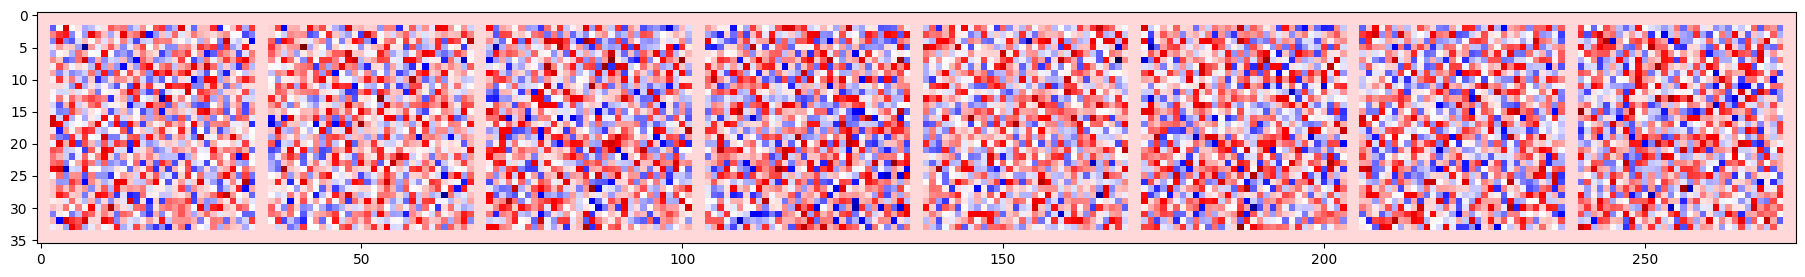

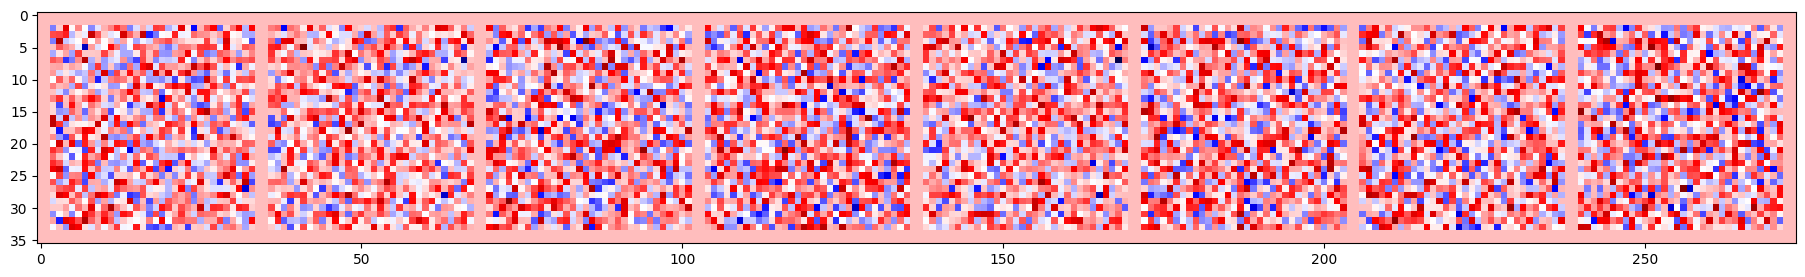

In [ ]:
# if len(img_features.shape) > 2:
#     fig = plt.figure(figsize=(24, 3))
#     img_features_plt = make_grid(img_features)[0].cpu().detach().numpy()
#     plt.imshow(img_features_plt, cmap="seismic"); plt.show()

#     fig = plt.figure(figsize=(24, 3))
#     data_features_plt = make_grid(data_features)[0].cpu().detach().numpy()
#     plt.imshow(data_features_plt, cmap="seismic"); plt.show()
# else:
#     pca = PCA(n_components=2)
#     img_features_pca = pca.fit_transform(img_features.cpu().detach().numpy())
#     data_features_pca = pca.fit_transform(data_features.cpu().detach().numpy())
#     fig = plt.figure(figsize=(10, 10))
#     plt.scatter(img_features_pca[:, 0], img_features_pca[:, 1], cmap="seismic")
#     plt.scatter(data_features_pca[:, 0], data_features_pca[:, 1], cmap="seismic"); plt.show()

In [3]:
# # Evaluate dataset
# N = len(dataset)
# for i in range(N):
#     d_path = dataset.data_paths[i]
#     d_name = d_path.split("/")[-1].split(".")[0] 
#     img, data = dataset[i]
    
#     image_features = model.encode_image(img.unsqueeze(0).to(next(iter(model.parameters())).device)).detach().cpu().numpy()
#     data_features = model.encode_data(data.unsqueeze(0).to(next(iter(model.parameters())).device)).detach().cpu().numpy()

#     np.save(f"./exps/{wandb_run.name}/embeddings/{d_name}-sclip-data-features.npy", data_features[0])
#     np.save(f"./exps/{wandb_run.name}/embeddings/{d_name}-sclip-image-features.npy", image_features[0])